## Imports

In [1]:
import cv2
import numpy as np
from numpy import save
import math as m
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from numpy import moveaxis
from numpy import asarray
import torch
from scipy.stats import multivariate_normal
import torchvision
from torch.linalg import multi_dot
from HyperParameters import *
from Functions import *


## Read data

In [2]:
imgRef = torchvision.io.read_image(PathImg1)
imgTar = torchvision.io.read_image(PathImg2)

refKey = torch.tensor(np.load(PathNPY1), device=DEVICE)
tarKey = torch.tensor(np.load(PathNPY2), device=DEVICE)

height, width = imgRef.shape[1], imgRef.shape[2]

## PlayGround

tensor(255, dtype=torch.uint8)


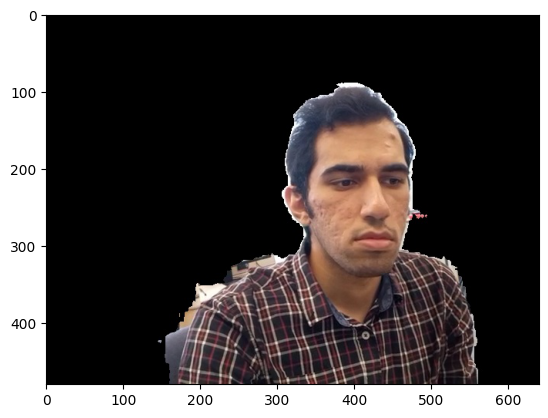

In [3]:
output = RenderImage(height, width, refKey, tarKey, imgTar)
showImageTensor(imgTar, is3chan=True)
# showImageTensor(output, isOutput=True)

tensor(255, dtype=torch.uint8)


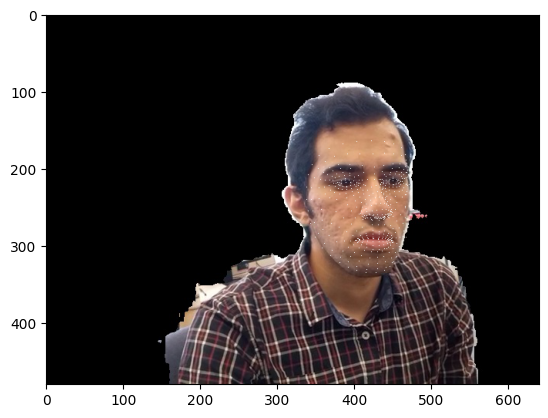

In [5]:
mm = createMask(tarKey, height, width, imgTar)
showImageTensor(mm, is3chan=True)

In [6]:
mm

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8)

tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)
tensor(255, dtype=torch.int32)


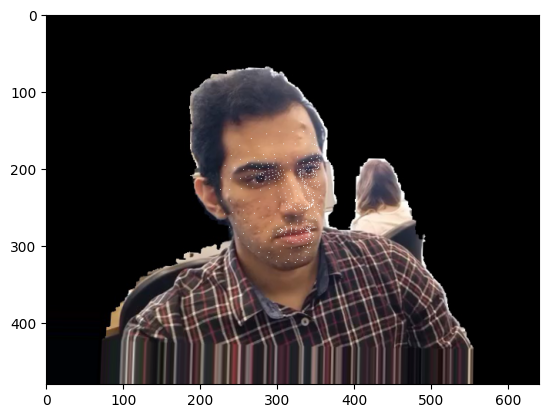

In [12]:
frameSize = (640, 480)

out = cv2.VideoWriter('idk.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 50
j = 50
k = 50
T = -torch.mean(tarKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
for j in range(50, 70):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)
 
  output = RenderImage(height, width, refKey, newKeys, imgRef)
  
  dummy = torch.squeeze(output)
  dummy = createMask(newKeys, height, width, dummy).int()
  
  img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
  
  img = np.moveaxis(np.uint8(img), 0, -1)
  
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# for j in range(100):
#   euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
#   # T = torch.tensor([0, 0, 0], device=DEVICE)
#   newKeys = TransformKeys(tarKey, euler, T)
#   output = RenderImage(height, width, refKey, newKeys, imgRef)
#   dummy = torch.squeeze(output)
#   dummy[:, (height*tarKey[:, 1]).long(), (width*tarKey[:, 0]).long()] = 1
#   img = showImageTensor(dummy, is3chan=True, returnOutput=True) * 255
#   # img = showImageTensor(output, isOutput=True, returnOutput=True) * 255
  
#   fuck = np.moveaxis(np.uint8(img), 0, -1)
  
#   out.write(cv2.cvtColor(fuck, cv2.COLOR_BGR2RGB))

# for k in range(100):
#   euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
#   # T = torch.tensor([0, 0, 0], device=DEVICE)
#   newKeys = TransformKeys(tarKey, euler, T)
#   output = RenderImage(height, width, refKey, newKeys, imgRef)
#   dummy = torch.squeeze(output)
#   dummy[:, (height*tarKey[:, 1]).long(), (width*tarKey[:, 0]).long()] = 1
#   img = showImageTensor(dummy, is3chan=True, returnOutput=True) * 255
#   # img = showImageTensor(output, isOutput=True, returnOutput=True) * 255
  
#   fuck = np.moveaxis(np.uint8(img), 0, -1)
  
#   out.write(cv2.cvtColor(fuck, cv2.COLOR_BGR2RGB))

out.release()

In [19]:
img.shape

(480, 640, 3)

In [ ]:
frameSize = (640, 480)

out = cv2.VideoWriter('keypoints.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 0
j = 0
k = 0
T = -torch.mean(tarKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
for i in range(100):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)

  output = createMask(newKeys, height, width) * 255


  img = showImageTensor(output, is3chan=False, isOutput=False, returnOutput=True)
  img = img.repeat(3,1,1)
  out.write(np.moveaxis(np.uint8(img), 0, -1))

for j in range(100):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)

  output = createMask(newKeys, height, width) * 255


  img = showImageTensor(output, is3chan=False, isOutput=False, returnOutput=True)
  img = img.repeat(3,1,1)
  out.write(np.moveaxis(np.uint8(img), 0, -1))


for k in range(100):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)

  output = createMask(newKeys, height, width) * 255


  img = showImageTensor(output, is3chan=False, isOutput=False, returnOutput=True)
  img = img.repeat(3,1,1)
  out.write(np.moveaxis(np.uint8(img), 0, -1))

out.release()